In [63]:
import numpy as np
import pymultinest as pmn
import matplotlib as plt

import os
import corner
import glob
import sys

from astropy.cosmology import wCDM, FlatwCDM
from astropy.cosmology import w0waCDM, Flatw0waCDM

In [33]:
os.getcwd()

'/Users/markpoe/ZTF/lowzSN/notebooks'

In [3]:
!which python

/Users/markpoe/astroml_miniconda3/bin/python


In [4]:
# wwcdm = wCDM(H0=70., Om0=0.3, Ode0=.7, w0= -1.)
# je = wwcdm.distmod(z=np.arange(0.01,.1,.003))
# print (je)
# print (len(je))

In [5]:
wwcdm = w0waCDM(H0=70., Om0=0.3, Ode0=.7, w0=-.9, wa=-.1)

In [ ]:
# wwcdm = w0waCDM(H0=70., Om0=0.3, Ode0=.7, w0=-.9, wa=-.1)

In [6]:
### Generate mu's by hand
data_path = '../jla_data/'
jla_bins = np.loadtxt(data_path + '/dist_binned.txt') ### original
cov_mat = np.loadtxt(data_path + 'covmat_binned.txt')

je = wwcdm.distmod((jla_bins[:,0]))
print (len(je))

l = np.sort(je)
print (l)

np.savetxt('by_hand.txt', l)
j = np.loadtxt('by_hand.txt', usecols = 0)

31
[33.1741933  33.57318958 33.91100502 34.20403771 34.58179929 35.00276554
 35.27354236 35.66302451 36.05620501 36.39144544 36.77371671 37.13970285
 37.48878507 37.84932859 38.23494338 38.6087138  38.98624    39.37493076
 39.76410141 40.14719681 40.5493109  40.94868162 41.35417632 41.76927921
 42.18348594 42.60823366 43.03196178 43.4638829  43.89809239 44.3320292
 44.76892843] mag


In [7]:
#define all the data here (currently SN only)

vs = np.vstack([sorted(jla_bins[:, 0]), sorted(jla_bins[:, 1])]).T # Transpose using jla original
vv = np.vstack([sorted(jla_bins[:, 0]), (j)]).T # Transpose using the by-hand array

np.savetxt('../jla_data/dist_binned_A.txt', vs) # Save the .T matrix
jla_bins_a = np.loadtxt(data_path + '/dist_binned_A.txt') # Load the .T matrix
np.savetxt('../jla_data/dist_binned_B.txt', vv) # Save the .T matrix using the by-hand array
jla_bins_b = np.loadtxt('../jla_data/dist_binned_B.txt')# Load the .T by-hand matrix

cov_mat *= 1e-6
Cinv = np.linalg.inv(cov_mat)

In [61]:
def llhood(model_param, ndim, npar):
    """
    This is the function where we define the log likelihood 
    log(Lhood) = -0.5*chisquare
    
    Parameters
    ----------
    model_param : sequence
        sequence of model parameters (Om, w, H0, M)
        in a wCDM    
    ndim : integer
         length of model_params
    npar : integer
        The number of parameters 
    """
    
    ### Calculate mu using priors and z from jla
    om, w0, wa, H0, M = [model_param[i] for i in range(5)]
#     wc = Flatw0waCDM(H0, om, w0=w0, wa=wa)
    wc = wcdm()
    wc = w0waCDM(H0=H0, Om0=om, Ode0=1-om, w0=w0, wa=wa)
    dl_mpc = wc.luminosity_distance(jla_bins[:,0]).value # Using jla data
    mu_th = 5*np.log10(dl_mpc) + 25.
    
    ### Calulate chi2 using (mu_th) - (mu_some_input_such_as_jla or by hand) 
#     dif_arr = mu_th - jla_bins_a[:,1] + M # Using jla mu .T
    dif_arr = mu_th - jla_bins_b[:,1] + M # Using by-hand data
    
    chisq = np.dot(dif_arr.T, np.dot(Cinv, dif_arr)) + ((om - 0.3)**2.)/((1e-15)**2.)
    return -0.5*chisq
    
def prior(cube, ndim, npar):
    """
    Define the prior for each parameter
    cube[0] = om
    cube[1] = w0
    cube[2] = wa
    cube[3] = H0
    cube[4] = M
    
    """
    cube[0]  = cube[0]*1
    cube[1]  = cube[1]*4 - 2
    cube[2]  = cube[2]*6 - 3
    cube[3]  = cube[3]*75 + 50
    cube[4]  = cube[4]*50 - 25 #0.00000000000001
    

In [60]:
prefix = 'test6_mod_chi2'
chain_dir = ('/Users/markpoe/ZTF/lowzSN/notebooks/chains/' + prefix + '/')

if not os.path.exists(chain_dir):
    os.makedirs(chain_dir)

In [56]:
### Remember to reset live points in run.py to n_live_points = 700; when using this script

In [62]:
pmn.run(llhood, prior, 5, verbose=True, n_live_points=700, outputfiles_basename=chain_dir)

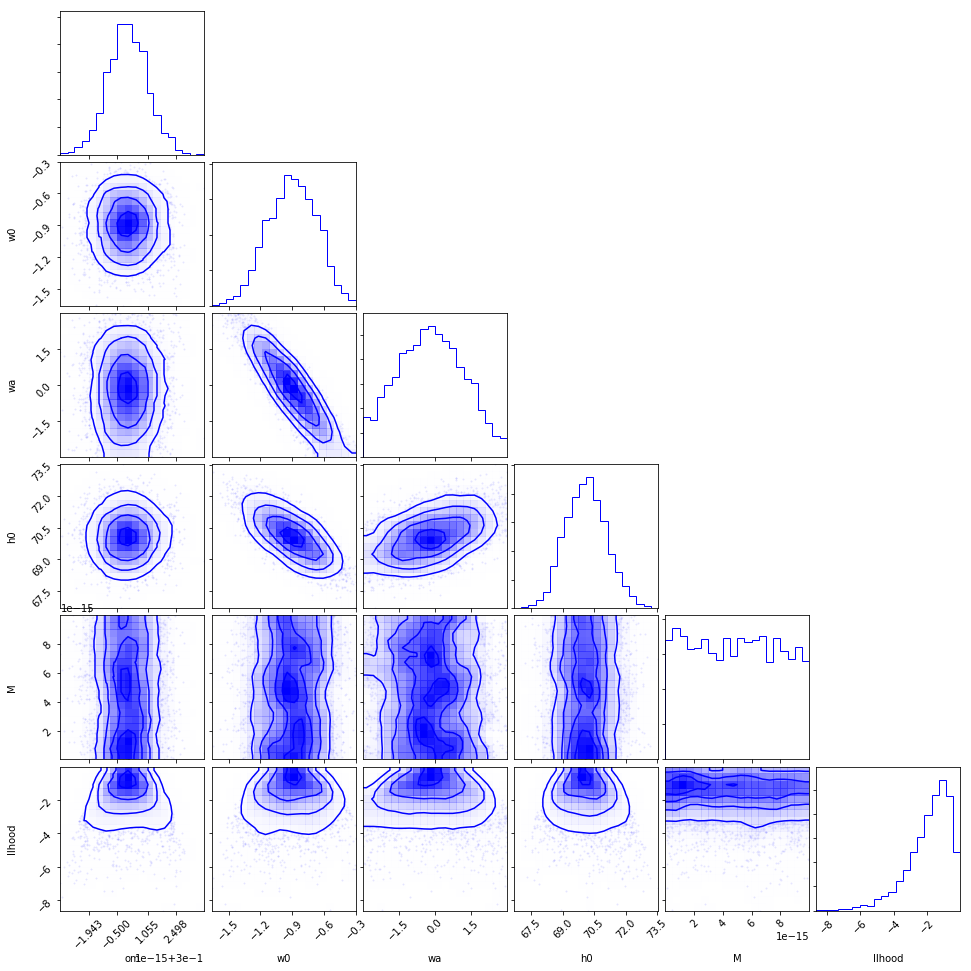

In [58]:
data = np.loadtxt(chain_dir+'post_equal_weights.dat')
figure = corner.corner(data, smooth=1, labels=['om', 'w0', 'wa', 'h0', 'M', 'llhood'], color = 'b') #, truths=[.3,-1.,0.,70.,25,100])

In [102]:
! cat './chains/jla_w0waCDM-2/stats.dat' | grep Evidence

Nested Sampling Global Log-Evidence           :   -0.214062505912217631E+02  +/-    0.127492284732868250E+00
Nested Importance Sampling Global Log-Evidence:   -0.219385823724944977E+02  +/-    0.474434434616146580E-01


In [ ]:
# with open(chain_dir+'stats.dat', "r") as f:
#     for line in f:
#         print (line)
# f.close()

In [38]:
# data = np.loadtxt(chain_dir+'post_equal_weights.dat')
# figure = corner.corner(data, smooth=1.5, plot_contours=True, labels=['om', 'w0', 'wa', 'h0', 'M', 'llhood'], color='b')
# figure.savefig(prefix + '.png')

In [13]:
a = pmn.analyse.Analyzer(5, outputfiles_basename = chain_dir)

  analysing data from /Users/markpoe/ZTF/lowzSN/notebooks/chains/jla_w0waCDM-1/.txt


In [15]:
# data = a.get_data()
# print (data)